In [83]:
import random
import os
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.io import read_image
import matplotlib.pyplot as plt
from google.colab import drive
import json
import requests
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cpu for inference


In [84]:
drive.mount("/content/drive")
train_img_dir = './drive/MyDrive/crackTrain'
test_img_dir = './drive/MyDrive/crackTest'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


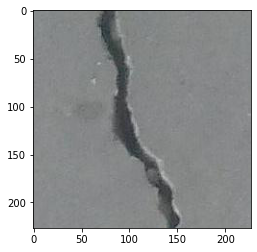

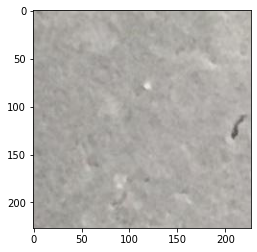

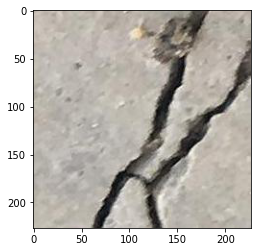

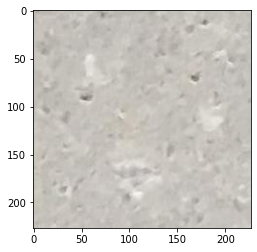

In [85]:
img_files = [os.path.join(train_img_dir, 'true/00001.jpg'),
             os.path.join(train_img_dir, 'false/00001.jpg'),
             os.path.join(test_img_dir, 'true/01001.jpg'),
             os.path.join(test_img_dir, 'false/01001.jpg')]

for img in img_files:
    plt.imshow(np.asarray(Image.open(img)))
    plt.show()

In [86]:
train_df = []


for i in range(1, 101):
  imgNum = "0"*(5 - len(str(i))) + str(i) + ".jpg"
  trueImg = "true/" + imgNum
  truePath = os.path.join(train_img_dir, trueImg)
  imgArr = np.asarray(Image.open(truePath))
  gray = np.dot(imgArr, [0.2989, 0.5870, 0.1140])
  flattened = gray.flatten()
  train_df.append(flattened)


for i in range(1, 101):
  imgNum = "0"*(5 - len(str(i))) + str(i) + ".jpg"
  falseImg = "false/" + imgNum
  falsePath = os.path.join(train_img_dir, falseImg)
  imgArr = np.asarray(Image.open(falsePath))
  gray = np.dot(imgArr, [0.2989, 0.5870, 0.1140])
  flattened = gray.flatten()
  train_df.append(flattened)


train_df = pd.DataFrame(train_df)
train_df.loc[train_df.index[:100], 'label'] = 1
train_df.loc[train_df.index[100:], 'label'] = 0

train_df = train_df.sample(frac=1)
train_df

,0,1,2,3,4,5,6,7,8,9,...,51520,51521,51522,51523,51524,51525,51526,51527,51528,label
48,217.0940,216.0941,215.0942,214.0943,214.0943,214.0943,216.0941,217.0940,218.0939,220.0937,...,203.1170,205.1168,207.1166,208.1165,207.1166,205.1168,202.1171,202.1171,203.1170,1.0
131,200.0849,192.0857,185.0864,184.0865,189.0860,191.6127,189.6129,185.6133,188.8410,189.8409,...,194.7695,196.7693,197.7692,197.7692,195.7694,192.7697,193.7696,194.7695,195.7694,0.0
91,120.8155,121.8154,123.8152,125.8150,126.8149,126.8149,125.8150,124.8151,123.8152,122.8153,...,144.1013,143.1014,141.1016,140.1017,139.1018,138.1019,139.1018,140.1017,141.1016,1.0
58,128.1245,126.1247,124.1249,124.1249,126.1247,130.1243,135.1238,138.1235,132.1241,129.1244,...,127.1246,127.1246,127.1246,127.1246,126.1247,125.1248,123.8152,123.8152,123.8152,1.0
149,201.1325,202.1324,203.1323,204.1322,204.1322,202.1324,200.1326,198.1328,197.1329,198.1328,...,198.0789,198.0789,196.0791,195.0792,196.0791,197.0790,200.0787,199.0788,198.0789,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,185.8907,184.8908,181.8911,179.8913,178.8914,177.8915,178.8914,178.8914,178.8914,181.8911,...,161.8931,158.8934,159.8933,163.8929,166.8926,167.8925,172.1201,175.1198,178.1195,0.0
69,117.8158,121.8154,125.8150,126.8149,126.8149,127.8148,129.8146,132.8143,126.8149,122.8153,...,119.1747,124.1742,125.1741,120.1746,117.1749,117.1749,115.8160,117.8158,119.8156,1.0
164,194.6448,203.6439,216.6426,219.6423,203.6439,180.6462,170.6472,173.6469,178.6464,178.6464,...,190.7915,190.7915,193.7912,194.7911,193.7912,190.7915,180.7925,180.7925,181.7924,0.0
63,123.8152,127.8148,132.8143,131.8144,127.8148,126.8149,128.8147,132.8143,129.8146,130.8145,...,117.1749,115.1751,121.1745,129.1737,129.1737,124.1742,110.8165,104.8171,100.8175,1.0


In [87]:
test_df = []


for i in range(1, 401):
  imgNum = "0"*(5 - len(str(1000+i))) + str(1000+i) + ".jpg"
  trueImg = "true/" + imgNum
  truePath = os.path.join(test_img_dir, trueImg)
  imgArr = np.asarray(Image.open(truePath))
  gray = np.dot(imgArr, [0.2989, 0.5870, 0.1140])
  flattened = gray.flatten()
  test_df.append(flattened)


for i in range(1, 401):
  imgNum = "0"*(5 - len(str(1000+i))) + str(1000+i) + ".jpg"
  falseImg = "false/" + imgNum
  falsePath = os.path.join(test_img_dir, falseImg)
  imgArr = np.asarray(Image.open(falsePath))
  gray = np.dot(imgArr, [0.2989, 0.5870, 0.1140])
  flattened = gray.flatten()
  test_df.append(flattened)


test_df = pd.DataFrame(test_df)
test_df.loc[test_df.index[:400], 'label'] = 1
test_df.loc[test_df.index[400:], 'label'] = 0

test_df = test_df.sample(frac=1)
test_df

,0,1,2,3,4,5,6,7,8,9,...,51520,51521,51522,51523,51524,51525,51526,51527,51528,label
307,179.0808,177.0810,172.0815,167.0820,165.0822,166.0821,171.0816,176.0811,179.0808,186.0801,...,164.2133,163.2134,165.2132,168.2129,171.2126,172.2125,170.2127,171.2126,172.2125,1.0
493,174.8918,175.8917,175.8917,175.8917,174.8918,174.8918,176.8916,178.8914,179.8913,174.8918,...,179.8913,174.8918,172.8920,172.8920,171.8921,170.8922,174.8918,177.8915,180.8912,0.0
472,214.0603,218.0599,223.0594,224.0593,223.0594,221.0596,222.0595,223.0594,222.0595,223.0594,...,224.0593,227.0590,228.0589,227.0590,225.0592,224.0593,224.0593,224.0593,224.0593,0.0
262,182.8003,181.8004,180.8005,179.8006,178.8007,177.9148,177.9148,176.9149,175.1431,176.1430,...,186.0989,188.0987,186.0989,184.0991,182.0993,181.0994,180.0995,180.0995,180.0995,1.0
488,197.8339,199.8337,199.8337,197.8339,194.8342,193.8343,194.8342,197.8339,192.8344,195.8341,...,190.0627,192.0625,207.0610,214.0603,215.0602,223.0594,215.2882,193.2904,185.2912,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701,207.0780,209.0778,210.0777,212.0775,212.0775,210.0777,208.0779,206.0781,205.0782,204.0783,...,185.0694,184.0695,184.0695,186.0693,188.0691,189.0690,194.0793,195.0792,196.0791,0.0
390,186.8089,187.8088,189.8086,191.8084,190.8085,190.4064,187.4067,186.4068,191.1182,191.1182,...,186.9229,185.9230,184.9231,183.9232,182.9233,181.9234,174.9241,174.9241,174.9241,1.0
734,180.2503,190.2493,197.2486,195.2488,194.2489,198.2485,199.2484,196.2487,190.2493,191.2492,...,168.8924,172.8920,172.8920,173.8919,179.8913,188.8904,200.1173,202.1171,205.1168,0.0
757,161.1212,162.1211,165.1208,166.1207,166.1207,163.1210,160.1213,158.1215,162.1211,163.1210,...,188.9721,188.9721,192.9717,196.9713,197.9712,196.9713,182.9619,180.9621,177.9624,0.0


In [88]:
from sklearn.svm import OneClassSVM
from sklearn.linear_model import LogisticRegression

X_train = train_df.drop('label', axis=1)  # features
y_train = train_df['label']  # labels

lgr = LogisticRegression()
lgr.fit(X_train, y_train)

X_test = test_df.drop('label', axis=1)  # features
y_test = test_df['label']  # labels


predictions = lgr.predict(X_test)

print(predictions)




[0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.
 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0.
 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0.
 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0.
 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0.
 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1.
 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0.
 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1.
 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1.
 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1.

In [89]:
labels = list(y_test)

In [90]:
total = 0
correct = 0
d = {}
for i in range(len(labels)):
  if str(labels[i]) + " " + str(predictions[i]) not in d:
    d[str(labels[i]) + " " + str(predictions[i])] = 0
  d[str(labels[i]) + " " + str(predictions[i])] += 1

cm = [[d['1.0 1.0'], d['0.0 1.0']],
                    [d['1.0 0.0'], d['0.0 0.0']]]

precision = cm[0][0] / (cm[0][0] + cm[0][1])
recall = cm[0][0] / (cm[0][0] + cm[1][0])
f1 = (precision * recall) / ((precision + recall) / 2)
accuracy = (cm[1][1] + cm[0][0])  / (cm[1][1] + cm[0][1] + cm[1][0] + cm[0][0])

print("Confusion Matrix")
print(cm[0])
print(cm[1])
print("\nPrecision:", round(precision, 3))
print("Recall:", round(recall, 3))
print("F1 score:", round(f1, 3))
print("Accuracy:", round(accuracy, 3))

Confusion Matrix
[333, 11]
[67, 389]

Precision: 0.968
Recall: 0.833
F1 score: 0.895
Accuracy: 0.902


In [ ]:
'''
trained on 200 images

Confusion Matrix
[333, 11]
[67, 389]

Precision: 0.968
Recall: 0.833
F1 score: 0.895
Accuracy: 0.902
'''

In [91]:
'''
trained on 600 images

Confusion Matrix
[354, 10]
[46, 390]

Precision: 0.973
Recall: 0.885
F1 score: 0.927
Accuracy: 0.93
'''

'\ntrained on 600 images\n\nConfusion Matrix\n[354, 10]\n[46, 390]\n\nPrecision: 0.973\nRecall: 0.885\nF1 score: 0.927\nAccuracy: 0.93\n'

In [92]:
'''
trained on 1000 images

Confusion Matrix
[355, 22]
[45, 378]

Precision: 0.942
Recall: 0.887
F1 score: 0.914
Accuracy: 0.916
'''

'\ntrained on 1000 images\n\nConfusion Matrix\n[355, 22]\n[45, 378]\n\nPrecision: 0.942\nRecall: 0.887\nF1 score: 0.914\nAccuracy: 0.916\n'

In [93]:
'''
trained on 2000 images

Confusion Matrix
[355, 23]
[45, 377]

Precision: 0.939
Recall: 0.887
F1 score: 0.913
Accuracy: 0.915
'''

'\ntrained on 2000 images\n\nConfusion Matrix\n[355, 23]\n[45, 377]\n\nPrecision: 0.939\nRecall: 0.887\nF1 score: 0.913\nAccuracy: 0.915\n'